In [ ]:
# Some tests that calculate known geometric quantities

# restart the kernel to clear past work
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

In [1]:
# load the required python modules
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import odeint
import time
import sys
import random
import matplotlib.pyplot as plt
%matplotlib inline

# homemade code
sys.path.append('../source')
from initialdata.mytests import *
from backgrounds.sphericalbackground import *
from core.spacing import *
from core.display import set_grid_on_ax
from core.statevector import *
from core.grid import Grid
from bssn.tensoralgebra import *
from bssn.hamdiagnostic import *
from matter.nomatter import *

# Set up matter
my_matter = NoMatter()
my_state = StateVector(my_matter)

# Input parameters for grid and evolution here
r_max = 9.0 # outer edge of the grid (including ghosts)
num_points = 100

# CubicSpacing
spacing = LinearSpacing(num_points, r_max)
grid = Grid(spacing, my_state)
r = grid.r
background = FlatSphericalBackground(r)

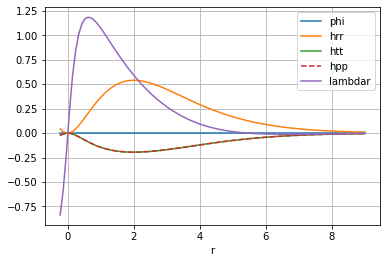

In [2]:
# This test sets up values such that R is known but phi = 0
state = get_test_state_1(grid, background)

#unpackage the vector for readability
phi, hrr, htt, hpp, K, arr, att, app, lambdar, shiftr, br, lapse = np.array_split(state, grid.NUM_VARS)

#plot initial conditions
plt.xlabel('r')
r = grid.r
plt.plot(r, phi, label='phi')
plt.plot(r, hrr, label='hrr')
plt.plot(r, htt, label='htt')
plt.plot(r, hpp, '--', label='hpp')
plt.plot(r, lambdar, label='lambdar')
plt.legend(loc='best')
plt.grid()

In [6]:
# calculate the diagnostics, the Ham constraint should just have 
# the term in bar_R so this tests the calculation of that quantity

#unpackage the state vector into the bssn vars in tensor form 
# Just for readability and ease of indexing
r = grid.r
N = grid.N
NUM_VARS = grid.NUM_VARS
unflattened_state = state.reshape(NUM_VARS, -1)
    
# First the metric vars in tensor form - see bssnvars.py
bssn_vars = BSSNVars(N)
bssn_vars.set_bssn_vars(unflattened_state)
    
# get the derivatives of the bssn vars in tensor form - see bssnvars.py
d1 = grid.get_d1_metric_quantities(unflattened_state)
d2 = grid.get_d2_metric_quantities(unflattened_state)
advec = grid.get_advection_d1_metric_quantities(unflattened_state, bssn_vars.shift_U)
    
# Limit the conformal factor so it doesn't blow up near BHs
em4phi = np.exp(-4.0*bssn_vars.phi)

# Test quantities
bar_R_test = np.zeros_like(phi)
chris_rrr  = np.zeros_like(phi)
chris_ttr  = np.zeros_like(phi)
chris_ppr  = np.zeros_like(phi)
Ricci_rr   = np.zeros_like(phi)
Ricci_tt   = np.zeros_like(phi)
Ricci_pp   = np.zeros_like(phi)
    
# Calculate some useful quantities
########################################################

# (unscaled) \bar\gamma_ij and \bar\gamma^ij
bar_gamma_LL = get_bar_gamma_LL(r, bssn_vars.h_LL, background)
bar_gamma_UU = get_bar_gamma_UU(r, bssn_vars.h_LL, background)

# The connections Delta^i, Delta^i_jk and Delta_ijk
Delta_U, Delta_ULL, Delta_LLL  = get_tensor_connections(r, bssn_vars.h_LL, d1.h_LL, background)

#print(bssn_vars.h_LL[:,i_r,i_r])
#print(d1.h_LL[:,i_t,i_t,i_r])

bar_chris = get_bar_christoffel(r, Delta_ULL, background)  
chris_rrr = bar_chris[:,i_r,i_r,i_r]
chris_ttr = bar_chris[:,i_t,i_t,i_r]
chris_ppr = bar_chris[:,i_p,i_p,i_r] 
    
bar_Rij = get_bar_ricci_tensor(r, bssn_vars.h_LL, d1.h_LL, d2.h_LL, bssn_vars.lambda_U, d1.lambda_U, 
                         Delta_U, Delta_ULL, Delta_LLL, 
                         bar_gamma_UU, bar_gamma_LL, background)
            
Ricci_rr = bar_Rij[:,i_r,i_r]
Ricci_tt = bar_Rij[:,i_t,i_t]
Ricci_pp = bar_Rij[:,i_p,i_p]

bar_R_test = get_trace(bar_Rij, bar_gamma_UU)

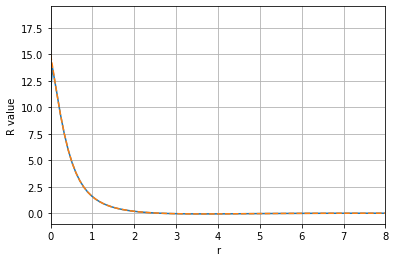

In [7]:
# Plot the Ricci scalar
plt.plot(r, bar_R_test, '-')

# compare to analytic result for R for test 1
epowr = np.exp(r)
tmp = (1.0 + r*r/epowr)**(0.5)
R_analytic = (1.0 / 8.0 / (r*r) * (epowr + r*r)**(-3.0) * 
              (16.0 * (r**6.0) * tmp
               - epowr * (r**4.0) * (-20.0  + 12.0*r + 7.0*r*r - 48.0*tmp)
               + 16.0 * epowr**3.0 * (-1.0 + tmp)
               + 8.0 * epowr**2.0 * r*r * (8.0 - 9.0*r + r*r + 6 * tmp)))

plt.plot(r, R_analytic, '--')

plt.xlabel('r')
plt.ylabel('R value')
plt.xlim(0,8)
#plt.ylim(0,1)
plt.grid()

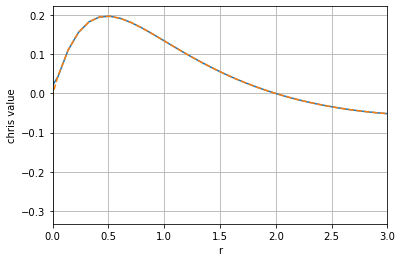

In [8]:
# Plot christoffels
plt.plot(r, chris_rrr)
#plt.plot(r, Delta_ULL[:,i_r,i_r,i_r], ':')
#plt.plot(r, background.hat_christoffel[:,i_r,i_r,i_r], '--')

# compare to analytic result for R for test 1
epowr = np.exp(r)
x = r
chris_rrr_analytic = -(0.5 * x * (x-2.0) / (epowr + x*x))
plt.plot(x, chris_rrr_analytic, '--')

plt.xlabel('r')
plt.ylabel('chris value')
plt.xlim(0,3)
#plt.ylim(0,1)
plt.grid()

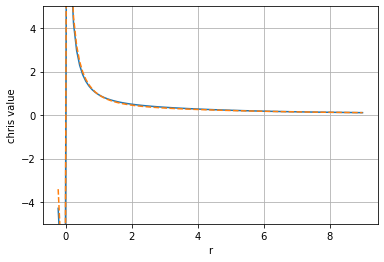

In [9]:
# Plot christoffels
plt.plot(r, chris_ttr)

# compare to analytic result for R for test 1
epowr = np.exp(r)
x = r
chris_ttr_analytic = (( 4.0 * epowr + 2.0*x + x**3.0 ) / (4.0 * x * epowr + 4.0 * x**3.0))
plt.plot(x, chris_ttr_analytic, '--')

plt.xlabel('r')
plt.ylabel('chris value')
#plt.xlim(0,3)
plt.ylim(-5,5)
plt.grid()

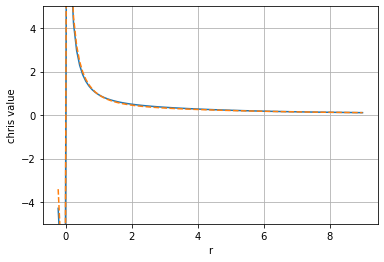

In [10]:
# Plot christoffels
plt.plot(r, chris_ppr)

# compare to analytic result for R for test 1
epowr = np.exp(r)
x = r
chris_ppr_analytic = chris_ttr_analytic
plt.plot(x, chris_ppr_analytic, '--')

plt.xlabel('r')
plt.ylabel('chris value')
#plt.xlim(0,3)
plt.ylim(-5,5)
plt.grid()

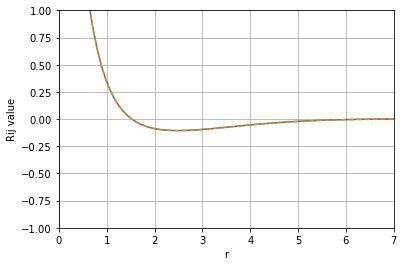

In [11]:
# Plot comps of Ricci - R_rr
plt.plot(r, Ricci_rr, '-')

# compare to analytic result for R for test 1
epowr = np.exp(r)
x = r
Ricci_analytic = ( (1.0/8.0) * (epowr + x*x)**-2.0 
              * ( x*x * (12 - 4.0*x - 3.0*x*x) 
                  + 4.0 * epowr * (10.0 - 8.0*x + x*x)))
plt.plot(x, Ricci_analytic, '--')

plt.xlabel('r')
plt.ylabel('Rij value')
plt.xlim(0,7)
plt.ylim(-1,1)
plt.grid()

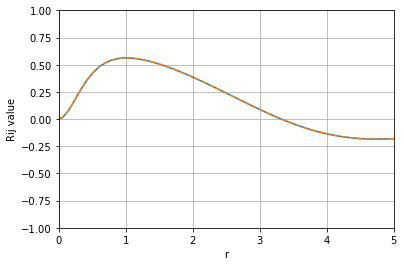

In [12]:
# Plot comps of Ricci - R_tt
plt.plot(r, Ricci_tt)

# compare to analytic result for R for test 1
epowr = np.exp(r)
x = r
tmp = (1.0 + x*x/epowr)**(0.5)
Ricci_analytic_tt = ( 0.25 * epowr**2.0 * tmp * ((epowr + x*x)**(-4.0))
                  * ( -4.0 * epowr**2.0 
                     + epowr * x**2.0 * (6.0 -10.0*x +x*x) 
                     - x**4.0 * (-2.0 + 2.0*x + x*x))) + 1.0
plt.plot(x, Ricci_analytic_tt, '--')

plt.xlabel('r')
plt.ylabel('Rij value')
plt.xlim(0,5)
plt.ylim(-1,1)
plt.grid()

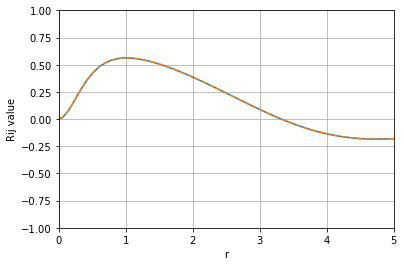

In [13]:
# Plot comps of Ricci - R_pp
plt.plot(r, Ricci_pp)

# compare to analytic result for R for test 1
epowr = np.exp(r)
x = r
Ricci_analytic_pp = Ricci_analytic_tt
plt.plot(x, Ricci_analytic_pp, '--')

plt.xlabel('r')
plt.ylabel('Rij value')
plt.xlim(0,5)
plt.ylim(-1,1)
plt.grid()

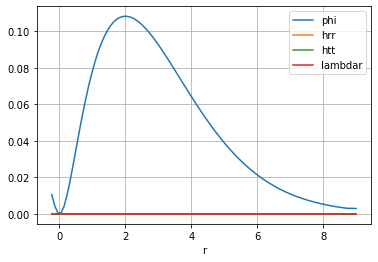

In [14]:
# This test sets up values such that R is known but bar_R = 0
state = get_test_state_2(grid, background)

#unpackage the vector for readability
phi, hrr, htt, hpp, K, arr, att, app, lambdar, shiftr, br, lapse = np.array_split(state, grid.NUM_VARS)

#plot initial conditions
plt.xlabel('r')
plt.plot(r, phi, label='phi')
plt.plot(r, hrr, label='hrr')
plt.plot(r, htt, label='htt')
plt.plot(r, lambdar, label='lambdar')
plt.legend(loc='best')
plt.grid()

In [15]:
Ham_test = get_Ham_diagnostic(state, 0, grid, background, my_matter)

#unpackage the state vector into the bssn vars in tensor form 
r = grid.r
N = grid.N
NUM_VARS = grid.NUM_VARS
unflattened_state = state.reshape(NUM_VARS, -1)
    
# First the metric vars in tensor form - see bssnvars.py
bssn_vars = BSSNVars(N)
bssn_vars.set_bssn_vars(unflattened_state)
    
# get the derivatives of the bssn vars in tensor form - see bssnvars.py
d1 = grid.get_d1_metric_quantities(unflattened_state)
d2 = grid.get_d2_metric_quantities(unflattened_state)

# Test quantities
bar_R_test = np.zeros(N)
chris_rrr  = np.zeros(N)
chris_ttr  = np.zeros(N)
chris_ppr  = np.zeros(N)
Ricci_rr   = np.zeros(N)
Ricci_tt   = np.zeros(N)
Ricci_pp   = np.zeros(N)
    
# Calculate some useful quantities
########################################################

# (unscaled) \bar\gamma_ij and \bar\gamma^ij
bar_gamma_LL = get_bar_gamma_LL(r, bssn_vars.h_LL, background)
bar_gamma_UU = get_bar_gamma_UU(r, bssn_vars.h_LL, background)

# The connections Delta^i, Delta^i_jk and Delta_ijk
Delta_U, Delta_ULL, Delta_LLL  = get_tensor_connections(r, bssn_vars.h_LL, d1.h_LL, background)
    
bar_chris = get_bar_christoffel(r, Delta_ULL, background)  
chris_rrr = bar_chris[:,i_r,i_r,i_r]
chris_ttr = bar_chris[:,i_t,i_t,i_r]
chris_ppr = bar_chris[:,i_p,i_p,i_r] 
    
bar_Rij = get_bar_ricci_tensor(r, bssn_vars.h_LL, d1.h_LL, d2.h_LL, bssn_vars.lambda_U, d1.lambda_U, 
                         Delta_U, Delta_ULL, Delta_LLL, 
                         bar_gamma_UU, bar_gamma_LL, background)

bar_R_test = get_trace(bar_Rij, bar_gamma_UU)

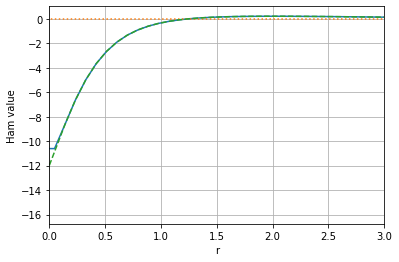

In [16]:
# Plot the result
plt.plot(r, Ham_test[0]) # should match R_analytic
plt.plot(r, bar_R_test, ':') # should be zero

#analytic result for test 2
epowr = np.exp(r)
x = r
R_analytic = - (0.5 * epowr * (epowr + x*x)**-3.0 
              * ( x*x * (12.0 - 12.0*x + x*x) 
                 + 4.0 * epowr * (6.0 - 6.0* x + x*x)))


plt.plot(x, R_analytic, '--')

plt.xlabel('r')
plt.ylabel('Ham value')
plt.xlim(0,3)
#plt.ylim(-12,1)
plt.grid()